In [91]:
!pip install -q -U keras-tuner

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import layers, Input
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.models import Sequential, Model
import keras_tuner as kt

import matplotlib.image as mpimg

from PIL import Image
import os
import glob


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

tf.__version__

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [93]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [198]:
# Before using the data need to upload on to drive
# This file will be deleted at the end of the session
# Go to file on left hand side of the screen then upload file (Can upload the file to root easier access)
# File extracted will be saved in content
from zipfile import ZipFile
file_name = '/trafficsigns_dataset.zip'
independent_file_name = '/independent_data.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

with ZipFile(independent_file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done
Done


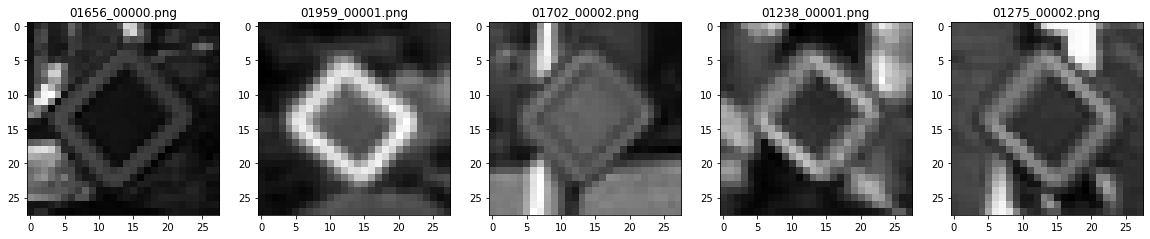

In [199]:
# This is just to test if image is loaded correctly
plt.figure(figsize=(20,20))
test_folder=r'/content/trafficsigns_dataset/diamond/rightofway'
for i in range(5):                                                    # Randomly loaded 5 images
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img, cmap = 'gray')

# **1. Data Preparation**
**Importing data into dataframe**

Data will be stored in a dataframe which has image path, shape and type as columns.

In [200]:
def file_path_into_dataframe(filepath):
  image_list = []

  for filepath in glob.glob(filepath, recursive=True):
      sign_shape = filepath.split('/')[2]
      sign_type = filepath.split('/')[3]
      image_list.append((filepath, sign_shape, sign_type ))
      
      
  # create a dataframe
  data = pd.DataFrame(data= image_list, columns=["image_path", 'sign_shape','sign_type'])
  # inspecting the dataframe
  return data

data = file_path_into_dataframe('./trafficsigns_dataset/*/*/*.png')
data.head()   

,image_path,sign_shape,sign_type
0,./trafficsigns_dataset/diamond/rightofway/0180...,diamond,rightofway
1,./trafficsigns_dataset/diamond/rightofway/0100...,diamond,rightofway
2,./trafficsigns_dataset/diamond/rightofway/0100...,diamond,rightofway
3,./trafficsigns_dataset/diamond/rightofway/0188...,diamond,rightofway
4,./trafficsigns_dataset/diamond/rightofway/0094...,diamond,rightofway


In [201]:
# data shape
data.shape

(3699, 3)

In [202]:
print("numbers of shape:", len(data.sign_shape.unique()))
data.sign_shape.unique()

numbers of shape: 5


array(['diamond', 'triangle', 'square', 'hex', 'round'], dtype=object)

In [203]:
print("numbers of type:", len(data.sign_type.unique()))
data.sign_type.unique()

numbers of type: 16


array(['rightofway', 'giveway', 'warning', 'laneend', 'crossing',
       'parking', 'continue', 'stop', 'roundabout', 'limitedtraffic',
       'traveldirection', 'trafficdirective', 'noparking', 'bicycle',
       'noentry', 'speed'], dtype=object)

**Labels encoding**

Using label encoder from sklearn to transform label into integer.

In [204]:
labelEncoder = LabelEncoder()
data.sign_shape = labelEncoder.fit_transform(data.sign_shape)
data.sign_type = labelEncoder.fit_transform(data.sign_type)
# inspecting the changes
data.head()

,image_path,sign_shape,sign_type
0,./trafficsigns_dataset/diamond/rightofway/0180...,0,9
1,./trafficsigns_dataset/diamond/rightofway/0100...,0,9
2,./trafficsigns_dataset/diamond/rightofway/0100...,0,9
3,./trafficsigns_dataset/diamond/rightofway/0188...,0,9
4,./trafficsigns_dataset/diamond/rightofway/0094...,0,9


**Data Distribution**

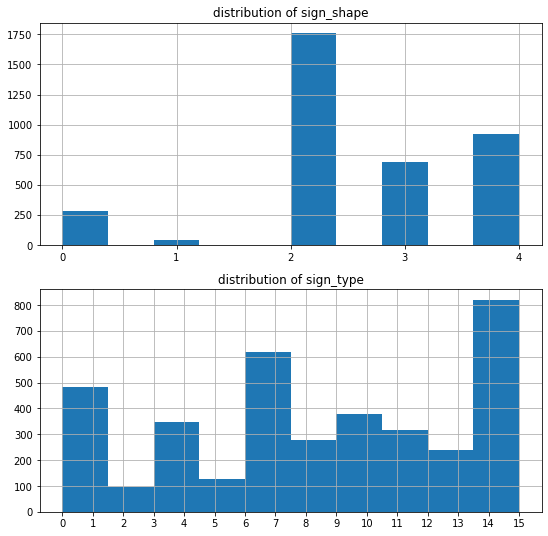

In [205]:
def plot_distribution(data):
  plt.figure(figsize=(9,9))
  for i in range(1,3):
      plt.subplot(2,1,i)
      data.iloc[:, i].sort_values().astype(str).hist()
      txt = "distribution of " + data.columns[i]
      plt.title(txt)
plot_distribution(data)

**<u>Observation</u>:**

 * Data has multiple classes for shape and type of the traffic sign
 * Class imbalance problem in both shape and type data <br>
 * performance measure : F1, log_loss and average accuracy(micro-average)<br>

What is the realistic result for performance measure?

# **2. Model Development**
* **Goal**: Implementing and comparing the performance of MLP and CNN model. 
* **Setup the experiment**: We will be using 80% of the original dataset as training data and 20% of the data to test (unseen data). From the 80% training data we will split again into 80% training and 20% validation data (data to evaluate the model).  
* Baseline Model:
* incremental changes:

## **2.1 Generating data**

### **Data Generator Utils**

All the functions that will be repeately used throughout `section 2.1` will be included in this section.

In [ ]:
# split data into train and test
train_data, test_data = train_test_split(data, random_state = random.randint(0, 100), test_size=0.2 )
train_data.shape, test_data.shape

((2959, 3), (740, 3))

In [143]:
def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

In [144]:
class dataGenerator:  
    def __init__(self, data, target):
        self.data = data
        self.target = target
        # split data into train and val
        self.train , self.val = self.split_data()
        
        
    def split_data(self):
        """
          Function to split input data into train, validation set
        """
        return train_test_split(self.data, random_state = random.randint(0, 100), test_size=0.2 )
    
    def generating_data_from_dataframe(self, dataframe, preprocessing_function = None):
        
        """
            Function to convert the refering target_column_name into string array
            and generate actual data from file path
        """
        dataframe.loc[:,self.target] = dataframe.loc[:,self.target].astype('str')
        if preprocessing_function is None:
          generator = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')
        else: 
          generator = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last', preprocessing_function = to_grayscale)
        batch_size = 32
        data_gen = generator.flow_from_dataframe(
                                                    dataframe = dataframe,
                                                    directory = './',
                                                    x_col = "image_path",
                                                    y_col = self.target,
                                                    target_size = (28, 28),
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical')
        return data_gen
        

### **2.1.1 Shape Data**

In [ ]:
# generate data for train & validation
dataShape = dataGenerator(train_data, "sign_shape")
train_shape = dataShape.generating_data_from_dataframe(dataShape.train)
validation_shape = dataShape.generating_data_from_dataframe(dataShape.val)

# generate test data
test_shape = dataGenerator(test_data, "sign_shape")
test_shape = test_shape.generating_data_from_dataframe(test_shape.data, None)

Found 2367 validated image filenames belonging to 5 classes.
Found 592 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


### **2.1.2 Type Data**

In [ ]:
# generate data for train & validation
dataType = dataGenerator(train_data, 'sign_type')

train_type = dataType.generating_data_from_dataframe(dataType.train)
validation_type = dataType.generating_data_from_dataframe(dataType.val)

# generate test data
test_type = dataGenerator(test_data, "sign_type")
test_type = test_type.generating_data_from_dataframe(test_type.data)

Found 2367 validated image filenames belonging to 16 classes.
Found 592 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


## **2.2 Model Development**

### **Model Development Utils**

All the functions that will be repeately used throughout `section 2.2` will be included in this section.

In [ ]:
input_dimension = (28,28,3)
numbers_of_shape = len(data.sign_shape.unique())
numbers_of_sign = len(data.sign_type.unique())

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                      monitor="val_loss",
                      min_delta=0.0001,
                      patience=5,
                      verbose=1,
                      mode="auto",
                      baseline=None,
                      restore_best_weights=True,
                  )

In [ ]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [ ]:
# calculate class weights to solve the imbalance class problem
class_weights_shape = class_weight.compute_class_weight('balanced',
                                                 classes = dataShape.train.sign_shape.unique(),
                                                 y = dataShape.train.sign_shape.to_numpy())
# convert to dict format
class_weight_dict_shape = dict()
i = 0
for w in class_weights_shape:
    class_weight_dict_shape[i] = w
    i= i+1

### **2.2.1 Multilayer Perceptrons Network**

#### **2.2.1.1 Shape Classification**

###### **2.2.1.1.1. Base Model**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(320, activation='sigmoid'),
    tf.keras.layers.Dense(5, 'softmax')
])

In [ ]:
compile_and_fit_model(model, train_shape, validation_shape)

###### **2.2.1.1.2 Hyperparameter Tuning Model**

In [ ]:

  
def parameters( layer, units, activation, dropout, lr,  numbers_of_label,  momentum):

  model = keras.Sequential([tf.keras.layers.Flatten(input_shape=INPUT_DM)])
  # Tune the number of layers
  for i in range(layer):
      model.add(layers.Dense(units=units, activation=activation))
  # tune dropout  
  if dropout:
      model.add(layers.Dropout(rate=0.5))
  # output layer
  model.add(layers.Dense(numbers_of_label, activation='softmax'))

  # loss function
  model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr,  momentum=momentum, nesterov=True),
                loss='CategoricalCrossentropy',
                metrics=['categorical_accuracy'])
  return model
  

  
  
def build_model(hp):
    # Declaring the number of layers to be tuned
    layer = hp.Int("num_layers", 1, 3)
    # Declaring the number of units per layer to be tuned
    units = hp.Int("units", min_value = 16, max_value = 512, step = 16)
    # Declaring the activaiton functionto be tuned
    activation = hp.Choice('activation', ['relu', 'tanh', 'elu','sigmoid'])
    dropout = hp.Boolean('dropout')
    # Declaring the learning rate range to be tuned
    lr = hp.Float('lr', min_value = 1e-4, max_value = 1e-2, sampling = 'log')
    momentum = hp.Float('momentum', min_value = 0.1, max_value = 0.9, sampling = 'log' )
    model = parameters( layer = layer, units = units, activation = activation, dropout = dropout,
    momentum = momentum, lr = lr, numbers_of_label =  numbers_of_shape )    
    return model

build_model(kt.HyperParameters())



In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(train_shape, epochs=300, validation_data=validation_shape,class_weight=class_weight_dict_shape , callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")])

Trial 2 Complete [00h 06m 33s]
val_categorical_accuracy: 0.9472972750663757

Best val_categorical_accuracy So Far: 0.9608108103275299
Total elapsed time: 00h 14m 44s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
3                 |2                 |num_layers
512               |480               |units
elu               |tanh              |activation
False             |True              |dropout
0.01              |0.0053453         |lr
0.1               |0.19864           |momentum

Epoch 1/100
93/93 [==============================] - 3s 28ms/step - loss: 2.1817 - categorical_accuracy: 0.3015 - val_loss: 2.2693 - val_categorical_accuracy: 0.2378
Epoch 2/100
93/93 [==============================] - 3s 30ms/step - loss: 0.9540 - categorical_accuracy: 0.6127 - val_loss: 0.5915 - val_categorical_accuracy: 0.7676
Epoch 3/100
93/93 [==============================] - 3s 30ms/step - loss: 1.3112 - categorical_accuracy: 0.5955 - val_loss: 0.6706 - val_categori

In [ ]:
tuner.results_summary()

In [ ]:
# get best model and best hyper parameter
best_model = tuner.get_best_models()[0]
best_hp = tuner.get_best_hyperparameters()[0]

In [ ]:
#best_model.build()
best_model.summary()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs

Retrain model with the best hyper parameters and plot the learing curve

In [ ]:
model = tuner.hypermodel.build(best_hp)
history = model.fit_generator(train_shape, validation_data = validation_shape, epochs=300, verbose=0, class_weight=class_weight_dict)
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

According to the above graphs, the best epoch is 70

In [ ]:
# Retrain the model with the best epoch
shape_model = tuner.hypermodel.build(best_hp)
shape_model.fit_generator(train_shape, validation_data = validation_shape, epochs=70, verbose=0)

Evaluating the model with test data

In [ ]:
shape_model = model.evaluate(test_shape)

#### **2.2.1.2 Type Classification**


###### **2.2.1.2.1 Base Model**

Build model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(320, activation='sigmoid'),
    tf.keras.layers.Dense(numbers_of_sign, 'softmax')
])

model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

model.summary()

Train Model

In [ ]:
history = model.fit_generator(train_type, validation_data=validation_type, epochs=50, verbose=0,)

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Evaluate Model

In [ ]:
model.evaluate(test_type)


##### **2.2.1.2.2 Hyperparameter Tuning Model**



In [ ]:
def parameters( layer, units, activation, dropout, lr,  numbers_of_label,  momentum):

    model = keras.Sequential([tf.keras.layers.Flatten(input_shape=INPUT_DM)])
    # Tune the number of layers
    for i in range(layer):
        model.add(layers.Dense(units=units, activation=activation))
    # tune dropout  
    if dropout:
        model.add(layers.Dropout(rate=0.5))
    # output layer
    model.add(layers.Dense(numbers_of_label, activation='softmax'))

    # loss function
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr,  momentum=momentum, nesterov=True),
                 loss='CategoricalCrossentropy',
                 metrics=['categorical_accuracy'])
    return model
    

  
  
def build_model(hp):
    # Declaring the number of layers to be tuned
    layer = hp.Int("num_layers", 1, 3)
    # Declaring the number of units per layer to be tuned
    units = hp.Int("units", min_value = 16, max_value = 512, step = 16)
    # Declaring the activaiton functionto be tuned
    activation = hp.Choice('activation', ['relu', 'tanh', 'elu'])
    dropout = hp.Boolean('dropout')
    # Declaring the learning rate range to be tuned
    lr = hp.Float('lr', min_value = 1e-4, max_value = 1e-2, sampling = 'log')
    momentum = hp.Float('momentum', min_value = 0.1, max_value = 0.9, sampling = 'log' )
    model = parameters(layer = layer, units = units, activation = activation, dropout = dropout,
    momentum = momentum, lr = lr, numbers_of_label =  NUMBERS_OF_SHAPE)    
    return model

build_model(kt.HyperParameters())


In [ ]:
# grid search
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective=  "val_categorical_accuracy",
    max_trials=2,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [ ]:
# calculate class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                 dataType.train.sign_type.unique(),
                                                 dataType.train.sign_type.to_numpy())
# convert to dict format
class_weight_dict = dict()
i = 0
for w in class_weights:
    class_weight_dict[i] = w
    i= i+1

In [ ]:
tuner.search(train_type, epochs=200, validation_data=validation_type, class_weight=class_weight_dict) #, callbacks=[stop_early]

In [ ]:
tuner.results_summary()

In [ ]:
best_model = tuner.get_best_models()[0]
best_hp = tuner.get_best_hyperparameters()[0]
best_model.summary()

In [ ]:
model = tuner.hypermodel.build(best_hp)
history = model.fit_generator(train_type, validation_data = validation_type, epochs=200, verbose=0, class_weight=class_weight_dict)

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
type_model = tuner.hypermodel.build(best_hp)
type_model.fit_generator(train_type, validation_data = validation_type, epochs=250, verbose=0)

type_model.evaluate(test_type)

### **2.2.2 Convolution Neural Network**

In this section, we will implement two popular CNN architectural namely VGG and LeNet as our baseline model. Depending on the result, we will configure the architecture so as to be able to figure out the best solution for this image classification problem.

#### **A. VGG CNN Baseline Model**


The VGG architecture that was used as the baseline model for this project is the modified architecture that was provided in the lecture (**link**). 

This modified architecture was chosen over the original VGG architecture as the original one contains many VGG - block (convolution + activation + pooling) and it is more suitable for larger image, however, our image is only of 28 * 28, which makes the modified version preferable. 

In [ ]:
VGG_model = tf.keras.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', input_shape=input_dimension),
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(numbers_of_shape, activation = "softmax"),
    ])
VGG_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 28)        784       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 28)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        16192     
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

#### **B. LeNet CNN Baseline Model**

In [94]:
reg_lambda = 0.001

LeNet_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_dimension),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(numbers_of_shape, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])



#### **2.2.2.1 Shape Classification**

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


74/74 [==============================] - 18s 232ms/step - loss: 1.4192 - categorical_accuracy: 0.4702 - val_loss: 1.2594 - val_categorical_accuracy: 0.4696
Epoch 2/100
74/74 [==============================] - 17s 230ms/step - loss: 1.2442 - categorical_accuracy: 0.4825 - val_loss: 1.1835 - val_categorical_accuracy: 0.5084
Epoch 3/100
74/74 [==============================] - 17s 228ms/step - loss: 1.1981 - categorical_accuracy: 0.5158 - val_loss: 1.1007 - val_categorical_accuracy: 0.5811
Epoch 4/100
74/74 [==============================] - 16s 221ms/step - loss: 1.1185 - categorical_accuracy: 0.5564 - val_loss: 1.0061 - val_categorical_accuracy: 0.6419
Epoch 5/100
74/74 [==============================] - 19s 255ms/step - loss: 0.9849 - categorical_accuracy: 0.6451 - val_loss: 0.8702 - val_categorical_accuracy: 0.7179
Epoch 6/100
74/74 [==============================] - 17s 226ms/step - loss: 0.7731 - categorical_accuracy: 0.7414 - val_loss: 0.6320 - val_categorical_accuracy: 0.8108
Epoc

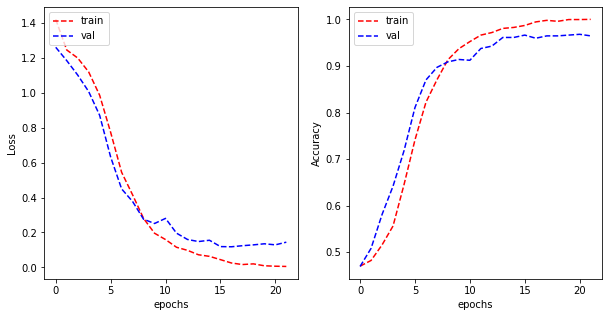

In [ ]:
VGG_model.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
# Early stopping is included to prevent long training time
# Training will be interupt if there is no further improvement in validation set
# restore_best_weights arguement is used to return the model to the best model
history = VGG_model.fit_generator(train_shape, validation_data = validation_shape, epochs=100, class_weight=class_weight_dict_shape, verbose=1,  callbacks = [early_stopping])
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [ ]:
# VGG_model.save("VGG_model")             

In [ ]:
# !cp -R ./VGG_model /content/gdrive/'My Drive'/COSC2673_2110/

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


74/74 [==============================] - 4s 53ms/step - loss: 1.4172 - categorical_accuracy: 0.4428 - val_loss: 1.2912 - val_categorical_accuracy: 0.4696
Epoch 2/100
74/74 [==============================] - 4s 49ms/step - loss: 1.3296 - categorical_accuracy: 0.4728 - val_loss: 1.2691 - val_categorical_accuracy: 0.4696
Epoch 3/100
74/74 [==============================] - 4s 49ms/step - loss: 1.3051 - categorical_accuracy: 0.4875 - val_loss: 1.2278 - val_categorical_accuracy: 0.4696
Epoch 4/100
74/74 [==============================] - 4s 50ms/step - loss: 1.2542 - categorical_accuracy: 0.5078 - val_loss: 1.1732 - val_categorical_accuracy: 0.5541
Epoch 5/100
74/74 [==============================] - 4s 49ms/step - loss: 1.2107 - categorical_accuracy: 0.5450 - val_loss: 1.1148 - val_categorical_accuracy: 0.6757
Epoch 6/100
74/74 [==============================] - 4s 50ms/step - loss: 1.1437 - categorical_accuracy: 0.5982 - val_loss: 1.0230 - val_categorical_accuracy: 0.6757
Epoch 7/100
74/7

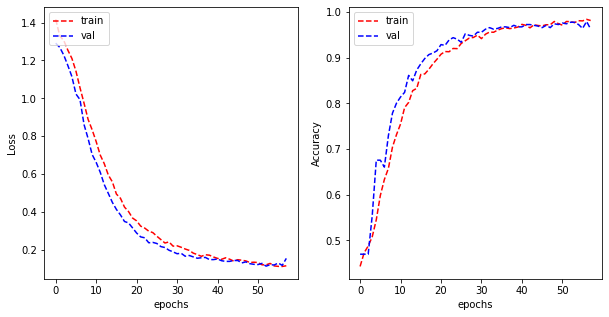

In [ ]:
LeNet_model.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
# Early stopping is included to prevent long training time
# Training will be interupt if there is no further improvement in validation set
# restore_best_weights arguement is used to return the model to the best model
history = LeNet_model.fit_generator(train_shape, validation_data = validation_shape, epochs=100, class_weight=class_weight_dict_shape, verbose=1, callbacks = [early_stopping])
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

**Observations:**
- Although the model has high accuracy and early-stopping has been implemented to prevent long training time as well as overfitting, it seems like the model is still overfit. 
- One of the reason for this is that in the base architecture of VGG that was used regularization and dropout has not been implemented. In the next sections, these 2 techniques to solve overfitting will be implemented. 

In [ ]:
# LeNet_model.save("LeNet_model")

INFO:tensorflow:Assets written to: LeNet_model/assets


In [ ]:
# !cp -R ./LeNet_model /content/gdrive/'My Drive'/COSC2673_2110/

##### **2.2.2.1.1 L2 Regularization (tuning regularization lambda)**

In [ ]:
def parameters(reg_lambda):
    VGG_model_with_regularization = tf.keras.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer = tf.keras.regularizers.L2(reg_lambda), input_shape=input_dimension),
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same',
                           kernel_regularizer= tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                  kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(reg_lambda)),
    tf.keras.layers.Dense(numbers_of_shape, activation = "softmax"),
    ])

    VGG_model_with_regularization.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
    return VGG_model_with_regularization
  
  
def build_model_VGG_l2_reg(hp):
    reg_lambda = hp.Choice('reg_lambda', [0.001, 0.01, 0.1, 1.0])
    model = parameters( reg_lambda = reg_lambda)
    return model

build_model_VGG_l2_reg(kt.HyperParameters())

In [ ]:
tuner = kt.RandomSearch(
    build_model_VGG_l2_reg,
    objective='val_loss',
    max_trials=3)
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
Search space summary
Default search space size: 1
reg_lambda (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1, 1.0], 'ordered': True}


In [ ]:
tuner.search(train_shape, epochs=100, verbose = 1, validation_data=validation_shape, class_weight=class_weight_dict_shape,  callbacks = [early_stopping])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.01              |?                 |reg_lambda

Epoch 1/100
74/74 [==============================] - 23s 299ms/step - loss: 8.6545 - categorical_accuracy: 0.2455 - val_loss: 8.6573 - val_categorical_accuracy: 0.2534
Epoch 2/100
74/74 [==============================] - 16s 216ms/step - loss: 7.9691 - categorical_accuracy: 0.2476 - val_loss: 7.2634 - val_categorical_accuracy: 0.2534
Epoch 3/100
74/74 [==============================] - 16s 215ms/step - loss: 7.6224 - categorical_accuracy: 0.2497 - val_loss: 7.1899 - val_categorical_accuracy: 0.2551
Epoch 4/100
74/74 [==============================] - 16s 217ms/step - loss: 7.1457 - categorical_accuracy: 0.3431 - val_loss: 6.6967 - val_categorical_accuracy: 0.2551
Epoch 5/100
74/74 [==============================] - 18s 239ms/step - loss: 6.3845 - categorical_accuracy: 0.5615 - val_loss: 5.9216 - val_categorical_accuracy: 0.7264
Epoch 6/100
74/74 [===========

KeyboardInterrupt: ignored

In [ ]:
tuner.results_summary()

In [ ]:
# get best model and best hyper parameter
best_model = tuner.get_best_models()[0]
best_hp = tuner.get_best_hyperparameters()[0]
best_model.summary()

In [ ]:
model_VGG_best_regularization = tuner.hypermodel.build(best_hp)
history = model_VGG_best_regularization.fit_generator(train_shape, validation_data = validation_shape, epochs=100, verbose=1, class_weight=class_weight_dict_shape, callbacks = [early_stopping])
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

##### **2.2.2.1.2 Dropout regularization (tuning dropout rate)**

In [ ]:
def parameters(reg_lambda, dropout_rate):
    VGG_model_with_regularization = tf.keras.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer = tf.keras.regularizers.l2(reg_lambda), input_shape=input_dimension),
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                  kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(rate = dropout_rate),
    tf.keras.layers.Dense(numbers_of_shape, activation = "softmax"),
    ])

    VGG_model_with_regularization.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
    return VGG_model_with_regularization
  

  
def build_model_VGG_dropout(hp):
    dropout_rate = hp.Choice('reg_lambda', [0.1, 0.2, 0.3, 0.4, 0.5])
    # Dropout rate is typically chosen between 10% to 50%. RNN usually use 20 - 30% while CNN normally use 40 - 50%
    model = parameters(reg_lambda = 0.001, dropout_rate = dropout_rate)
    return model

build_model_VGG_dropout(kt.HyperParameters())

In [ ]:
tuner = kt.RandomSearch(
    build_model_VGG_dropout,
    objective='val_loss',
    max_trials=3)
tuner.search_space_summary()

In [ ]:
tuner.search(train_shape, epochs=100, verbose = 1, validation_data=validation_shape, class_weight=class_weight_dict_shape,  callbacks = [early_stopping])

In [ ]:
tuner.results_summary()

In [ ]:
# get best model and best hyper parameter
best_model = tuner.get_best_models()[0]
best_hp = tuner.get_best_hyperparameters()[0]
best_model.summary()

In [ ]:
model_VGG_best_regularization = tuner.hypermodel.build(best_hp)
history = model_VGG_best_regularization.fit_generator(train_shape, validation_data = validation_shape, epochs=100, verbose=1, class_weight=class_weight_dict_shape, callbacks = [early_stopping])
  
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

## **2.3. Test Set Evaluation**

### **2.3.1. Test Set 1**

In [99]:
test_set_1_shape = test_shape
test_set_1_type = test_type

### **2.3.2. Test Set 2**

In [100]:
data_independent = file_path_into_dataframe('./independent_data/*/*/*.png')
data_independent.head()  

,image_path,sign_shape,sign_type
0,./independent_data/diamond/laneend/02333.png,diamond,laneend
1,./independent_data/diamond/laneend/1111.png,diamond,laneend
2,./independent_data/diamond/laneend/1232.png,diamond,laneend
3,./independent_data/diamond/rightofway/005.png,diamond,rightofway
4,./independent_data/diamond/rightofway/007.png,diamond,rightofway


In [101]:
data_independent.sign_shape = labelEncoder.fit_transform(data_independent.sign_shape)
data_independent.sign_type = labelEncoder.fit_transform(data_independent.sign_type)
data_independent.head()

,image_path,sign_shape,sign_type
0,./independent_data/diamond/laneend/02333.png,0,4
1,./independent_data/diamond/laneend/1111.png,0,4
2,./independent_data/diamond/laneend/1232.png,0,4
3,./independent_data/diamond/rightofway/005.png,0,9
4,./independent_data/diamond/rightofway/007.png,0,9


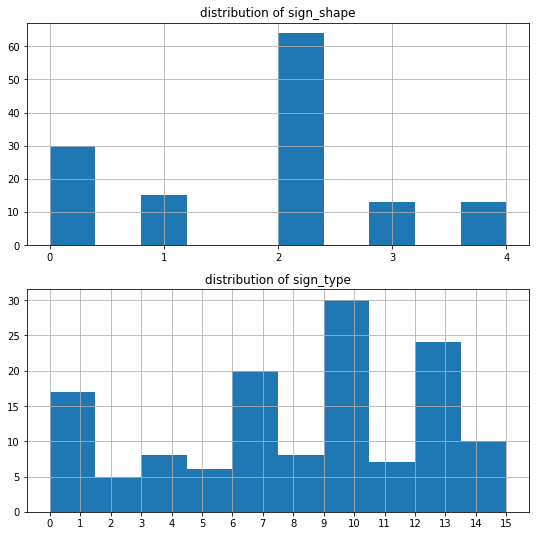

In [102]:
plot_distribution(data_independent)

In [159]:
test_set_2_shape = dataGenerator(data_independent, "sign_shape")
test_set_2_shape = test_set_2_shape.generating_data_from_dataframe(test_set_2_shape.data, to_grayscale)

Found 135 validated image filenames belonging to 5 classes.


In [160]:
test_set_2_type = dataGenerator(data_independent, "sign_type")
test_set_2_type = test_set_2_type.generating_data_from_dataframe(test_set_2_type.data, to_grayscale)

Found 135 validated image filenames belonging to 16 classes.


In [162]:
LeNet_Model = keras.models.load_model('/content/gdrive/MyDrive/COSC2673_2110/LeNet_model')

In [188]:
prediction = LeNet_Model.predict(test_set_2_shape)
predict_class = []
for item in np.round(prediction):
    predict_class.append(list(item).index(max(item)))
true_class = [int(f) for f in list(data_independent.sign_shape)]

[0, 2, 3, 3, 4, 2, 2, 2, 0, 2, 3, 2, 2, 4, 2, 2, 3, 2, 2, 3, 2, 4, 0, 3, 0, 2, 2, 0, 1, 0, 4, 2, 4, 4, 2, 2, 2, 2, 2, 2, 1, 0, 4, 2, 2, 3, 2, 0, 1, 2, 2, 4, 2, 2, 0, 2, 0, 2, 2, 2, 3, 1, 3, 3, 0, 2, 2, 2, 2, 0, 3, 2, 3, 2, 4, 0, 0, 2, 0, 2, 0, 3, 0, 0, 4, 1, 2, 4, 2, 2, 4, 4, 2, 1, 0, 2, 2, 2, 0, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 3, 2, 4, 0, 2, 0, 2, 2, 4, 2, 2, 2, 2, 2]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


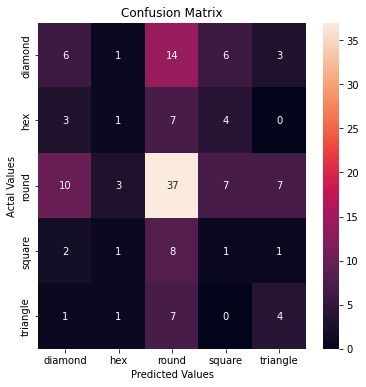

In [197]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_class, predict_class)

cm_df = pd.DataFrame(cm,
                     index = ['diamond','hex','round', 'square', 'triangle'], 
                     columns = ['diamond','hex','round', 'square', 'triangle'])

#Plotting the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


https://keras.io/guides/keras_tuner/getting_started/

https://keras.io/keras_tuner/

https://keras.io/guides/keras_tuner/visualize_tuning/

https://www.tensorflow.org/tutorials/keras/keras_tuner

Hoang check links for documentation on tuner